# Identity Resolutotion - FM and TM

## 1. Setup

In [1]:
from PyDI.entitymatching.blocking import TokenBlocker
import logging
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PyDI.entitymatching.blocking import StandardBlocker
from PyDI.entitymatching.evaluation import EntityMatchingEvaluator
from PyDI.entitymatching.blocking import NoBlocker, TokenBlocker
import time # Import time to measure runtime
from pathlib import Path
from PyDI.entitymatching.comparators import StringComparator, DateComparator 
from PyDI.entitymatching import RuleBasedMatcher
import matplotlib.pyplot as plt
import seaborn as sns
from PyDI.entitymatching import GreedyOneToOneMatchingAlgorithm, StableMatching, MaximumBipartiteMatching


c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

os.makedirs('logs/', exist_ok=True)

# choose either default logging or debug logging

# # Configure logging for INFO level
# logging.basicConfig(
#     level=logging.INFO,
#     format='[%(levelname)-5s] %(name)s - %(message)s',
#     handlers=[
#           logging.FileHandler('logs/pydi.log'),  # Save to file
#           logging.StreamHandler()                      # Display on console
#       ],
#     force=True
# )

# Configure logging for DEBUG level
logging.basicConfig(
    level=logging.DEBUG,
    format='[%(levelname)-5s] %(name)s - %(message)s',
    handlers=[
          logging.FileHandler('logs/pydi.log'),  # Save to file
          logging.StreamHandler()                      # Display on console
      ],
    force=True
)

In [3]:

# Setup directories
DATA_DIR = Path("data")
# --- MODIFICATION START: Update INPUT_DIR for the new folder ---
# Update the input directory to point to your specific folder
INPUT_DIR = DATA_DIR / "FM&TM" 
# --- MODIFICATION END ---
OUTPUT_DIR = DATA_DIR / "output"
SPLITS_DIR = DATA_DIR / "splits"

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# Ensure the new input directory exists (optional, but good practice)
INPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- MODIFIED FILE PATHS ---
# Define file paths for your CSV datasets

# Update FM_FILE name to match 'FM_pyDI.csv' and use the new INPUT_DIR
FM_FILE = INPUT_DIR / "FM_pyDI.csv"

# TM_FILE path remains relative to the new INPUT_DIR
TM_FILE = INPUT_DIR / "TM_pyDI.csv"

# Define file path for your single labeled pairs file. 
# Assuming Labeling_pairs_results.csv is still in 'data/splits'.
LABELED_PAIRS_FILE = SPLITS_DIR / "Labeling_pairs_results.csv"


# The original file paths are no longer needed
# TRAIN_FILE = SPLITS_DIR / "train.csv"
# VALIDATION_FILE = SPLITS_DIR / "validation.csv"
# TEST_FILE = SPLITS_DIR / "test.csv"
# --- END MODIFICATION ---

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Input directory (New): {INPUT_DIR.absolute()}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")
print(f"Loading FM data (FM) from: {FM_FILE}")
print(f"Loading TM data from: {TM_FILE}")
print(f"Loading Labeled Pairs from: {LABELED_PAIRS_FILE}")

Data directory: c:\Users\Eirik Solberg\Desktop\7. Semester (Mannheim)\Web data integration\Football-Dataset-Integration\data
Input directory (New): c:\Users\Eirik Solberg\Desktop\7. Semester (Mannheim)\Web data integration\Football-Dataset-Integration\data\FM&TM
Output directory: c:\Users\Eirik Solberg\Desktop\7. Semester (Mannheim)\Web data integration\Football-Dataset-Integration\data\output
Loading FM data (FM) from: data\FM&TM\FM_pyDI.csv
Loading TM data from: data\FM&TM\TM_pyDI.csv
Loading Labeled Pairs from: data\splits\Labeling_pairs_results.csv


## 2. Data Loading and EDA

In [4]:

# Load the datasets from CSV
# Load your FM_pyDI.csv file
df_FM = pd.read_csv(FM_FILE)
# Add metadata 
df_FM.attrs['source'] = 'FM_pyDI' 

# Load your TM_pyDI.csv file
df_TM = pd.read_csv(TM_FILE)
# Add metadata (optional, but good practice)
df_TM.attrs['source'] = 'TM_pyDI'

print(f"\nFM dataset (from FM_pyDI): {len(df_FM)} records")
print(f"Transfermarkt dataset (from TM_pyDI): {len(df_TM)} records")
print(f"\nTotal possible pairs (cartesian product): {len(df_FM) * len(df_TM):,}")

# IMPORTANT: After this, run the cells (like .head() and .isnull().sum()) 
# in the notebook to explore *your* data.


FM dataset (from FM_pyDI): 189345 records
Transfermarkt dataset (from TM_pyDI): 69441 records

Total possible pairs (cartesian product): 13,148,306,145


In [5]:
# Display sample records from Academy Awards
print("\n=== Sample records from Academy Awards dataset ===")
display(df_FM.head())

print("\n=== Missing values ===")
print(df_FM.isnull().sum())


=== Sample records from Academy Awards dataset ===


,pydi_id,player_name,positions_position,left_right_foot,date_of_birth,clubs_club,height_cm,nationality,transfer_value,career_appearances,career_goals,pace,finishing,passing,dribbling,tackling,strength,reflexes_gk,handling_gk,penalty
0,left_000000,Giorgio Chiellini,D (C),Left,1984-08-14,LAFC,187,ITA,-1,519,34,9,5,12,4,18,14,1,3,3
1,left_000001,Hulk,"AM (R), ST (C)",Left,1986-07-25,ATM,179,BRA,-1,465,270,14,15,15,14,8,18,2,4,16
2,left_000002,Luis Suárez,ST (C),Right,1987-01-24,Nacional,182,URU,650000,534,349,10,18,16,14,9,14,1,1,16
3,left_000003,Gonzalo Higuaín,ST (C),Right,1987-12-10,Inter Miami,184,ARG,900000,518,267,11,17,14,14,8,16,1,1,14
4,left_000004,Alex Teixeira,"AM (LC), ST (C)",Right,1990-01-06,VDG,173,BRA,2900000,344,141,13,13,12,15,5,7,1,2,13



=== Missing values ===
pydi_id                   0
player_name               0
positions_position        0
left_right_foot           0
date_of_birth             0
clubs_club            28245
height_cm                 0
nationality               0
transfer_value            0
career_appearances        0
career_goals              0
pace                      0
finishing                 0
passing                   0
dribbling                 0
tackling                  0
strength                  0
reflexes_gk               0
handling_gk               0
penalty                   0
dtype: int64


In [6]:
# Display sample records from Actors
print("\n=== Sample records from Actors dataset ===")
display(df_TM.head())

print("\n=== Missing values ===")
print(df_TM.isnull().sum())


=== Sample records from Actors dataset ===


,pydi_id,player_name,positions_position,date_of_birth,clubs_club,height_cm,nationality,transfer_value,left_right_foot
0,right_000000,silvio adzic,AMR,1980-09-23,Retired,0.0,Germany,0,NaN
1,right_000001,everton silva,DR,1988-08-04,Without Club,171.0,Brazil,50000,right
2,right_000002,miroslav klose,ST,1978-06-09,Retired,184.0,Germany,9000000,right
3,right_000003,john thompson,DR,1981-10-12,Retired,183.0,Ireland,325000,both
4,right_000004,carlos auzqui,AMR,1991-03-16,Club Atlético Tucumán,180.0,Argentina,100000,right



=== Missing values ===
pydi_id                   0
player_name               0
positions_position      519
date_of_birth           196
clubs_club                0
height_cm                 1
nationality               5
transfer_value            0
left_right_foot       10060
dtype: int64


## 3. Train test split and Development Set


In [7]:
# Load your single labeled file
try:
    df_all_labeled_pairs = pd.read_csv(LABELED_PAIRS_FILE)
except FileNotFoundError:
    print(f"ERROR: Labeled file not found at {LABELED_PAIRS_FILE}")
    print("Please check the file path and name in the previous cell.")
    # Stop execution if file isn't found
    raise


LABEL_COLUMN_NAME = 'label' 

# Check if the label column exists
if LABEL_COLUMN_NAME not in df_all_labeled_pairs.columns:
    print(f"ERROR: The label column '{LABEL_COLUMN_NAME}' was not found in your CSV.")
    print(f"Available columns are: {df_all_labeled_pairs.columns.tolist()}")
    print("Please update the 'LABEL_COLUMN_NAME' variable in this cell.")
    # Stop execution
    raise ValueError(f"Label column '{LABEL_COLUMN_NAME}' not found.")


# Split the data: 40% train, 30% validation, 30% test
# 'stratify' ensures that train, validation, and test sets have roughly the
# same percentage of TRUE/FALSE pairs as the original file. 

# Step 1: Split into Train (40%) and Temp (60%)
df_train, df_temp = train_test_split(
    df_all_labeled_pairs,
    test_size=0.6,  # 60% will be saved for temp
    random_state=42,  # for reproducible results
    stratify=df_all_labeled_pairs[LABEL_COLUMN_NAME]
)

# Step 2: Split Temp (60%) into Validation (30%) and Test (30%)
df_validation, df_test = train_test_split(
    df_temp,
    test_size=0.5,  # 50% of the temp set
    random_state=42,  # for reproducible results
    stratify=df_temp[LABEL_COLUMN_NAME]
)

print(f"Total labeled pairs loaded: {len(df_all_labeled_pairs)}")
print(f"  Training set:   {len(df_train)} pairs")
print(f"  Validation set: {len(df_validation)} pairs")
print(f"  Test set:       {len(df_test)} pairs")

# Display counts for verification
print("\nTraining set label distribution:")
print(df_train[LABEL_COLUMN_NAME].value_counts())

print("\nValidation set label distribution:")
print(df_validation[LABEL_COLUMN_NAME].value_counts())

print("\nTest set label distribution:")
print(df_test[LABEL_COLUMN_NAME].value_counts())

Total labeled pairs loaded: 480
  Training set:   192 pairs
  Validation set: 144 pairs
  Test set:       144 pairs

Training set label distribution:
label
0    134
1     58
Name: count, dtype: int64

Validation set label distribution:
label
0    100
1     44
Name: count, dtype: int64

Test set label distribution:
label
0    101
1     43
Name: count, dtype: int64


In [8]:
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## 4. Blocking(first 2 characters of the first 2 words) + Ruled-base model

 This implementation using the first three characters of the first 2 words in the player_name as an aggregated blocking key:

In [9]:

# First, we define a function to generate blocking keys
def generate_blocking_key(title):
    if not isinstance(title, str):
        return None
    
    tokens = title.split()
    blocking_key = ""
    
    for i in range(min(2, len(tokens))):
        blocking_key += tokens[i][:2].upper()
    
    return blocking_key if blocking_key else None

# Apply to DataFrames
df_FM['blocking_key'] = df_FM['player_name'].apply(generate_blocking_key)
df_TM['blocking_key'] = df_TM['player_name'].apply(generate_blocking_key)

# Apply standard blocking
blocker_standard = StandardBlocker(
    df_FM, df_TM,
    on=['blocking_key'],
    output_dir=OUTPUT_DIR / "blocking-evaluation",
    id_column='pydi_id'
)

# Materialize all candidate pairs
candidates_standard = blocker_standard.materialize()

print()
print(f"  Generated: {len(candidates_standard):,} candidates")

# Display sample candidates
display(candidates_standard.head(10))

[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating blocking key values for dataset1: 189345 records
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating blocking key values for dataset2: 69441 records
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 38128 blocking keys for first dataset
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 18435 blocking keys for second dataset
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Joining blocking key values: 38128 x 18435 blocks
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 16315 blocks from blocking keys
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Block size distribution:
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Size Frequency
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - 2871        1
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - 1974    


  Generated: 2,576,111 candidates


,id1,id2,block_key
0,left_000000,right_004907,dama
1,left_000000,right_012825,dama
2,left_000000,right_012836,dama
3,left_000000,right_022454,dama
4,left_000000,right_024783,dama
5,left_000000,right_027001,dama
6,left_000000,right_027492,dama
7,left_000000,right_031612,dama
8,left_000000,right_032895,dama
9,left_000000,right_034145,dama


Blocking evaluation

In [10]:

# Evaluate blocking quality using validation set
blocking_metrics_standard = EntityMatchingEvaluator.evaluate_blocking(
    candidate_pairs=candidates_standard,
    blocker=blocker_standard,
    test_pairs=df_validation,
    out_dir=OUTPUT_DIR / "blocking-evaluation"
)

[INFO ] root -   Pair Completeness: 0.932
[INFO ] root -   Pair Quality:      0.000
[INFO ] root -   Reduction Ratio:   0.999804
[INFO ] root -   True Matches Found: 41/44
[INFO ] root - Blocking evaluation complete!


set up baseline of time

In [11]:
# Make sure the validation set index is reset
df_validation = df_validation.reset_index(drop=True)

# --- 1. NoBlocker (Baseline for runtime) ---
# NoBlocker creates the full cartesian product (all possible pairs).
# This shows the maximum number of pairs and the worst-case runtime.

# Use a small subset to avoid MemoryError
df_FM_small = df_FM.sample(2000, random_state=42)
df_TM_small = df_TM.sample(2000, random_state=42)

print("--- Evaluating NoBlocker ---")
blocker_none = NoBlocker(
    df_FM_small, df_TM_small,
    id_column='pydi_id'
)

# Time the materialize step
start_time = time.time()
candidates_none = blocker_none.materialize()
end_time = time.time()

print(f"Generated: {len(candidates_none):,} candidates")
print(f"Runtime: {end_time - start_time:.4f} seconds")

# --- 2. TokenBlocker (1-word overlap on 'title') ---

--- Evaluating NoBlocker ---
Generated: 4,000,000 candidates
Runtime: 0.6372 seconds


#### Rule-Based Matching with Iterative Refinement

Now we'll build a rule-based matcher that computes a weighted similarity score for each candidate pair.

We'll start with a simple matcher using:
- **Player_name**: Levensthein similarity 
- **nationality**: Jaro-Winkler
- **positions_position**: Token-based Overlap Coefficient or Jaro-Winkler
- **clubs_club**: Jaro-Winkler

In [12]:

# 1. Define comparators based on your new rules
# The order in this list must match the order of the weights below
comparators = [
    # Rule 1: player_name (Weight: 0.6, Sim: Levenshtein)
    StringComparator(
        column="player_name",
        similarity_function="levenshtein",
        preprocess=str.lower  # Good practice to lowercase names
    ),
    
    # Rule 2: nationality (Weight: 0.2, Sim: Jaro-Winkler)
    StringComparator(
        column="nationality",
        similarity_function="jaro_winkler", # Jaro-Winkler similarity
        preprocess=str.lower
    ),
    
    # Rule 3: positions_position (Weight: 0.1, Sim: Token-based Overlap)
    # We choose Overlap Coefficient as it's a specific requirement
    StringComparator(
        column="positions_position",
        similarity_function='overlap', # Overlap 
        tokenization="word", # IMPORTANT: Treat column as list of tokens (e.g., "MF FW")
        preprocess=str.lower
    ),
    
    # Rule 4: clubs_club (Weight: 0.1, Sim: Jaro-Winkler)
    StringComparator(
        column="clubs_club",
        similarity_function="jaro_winkler",
        preprocess=str.lower
    )
]

# 2. Define the weights for the comparators
# Must be in the same order as the 'comparators' list
weights = [0.6, 0.2, 0.1, 0.1]

# 3. Define the similarity threshold
threshold = 0.65 # You can adjust this threshold as needed

# Initialize matcher
matcher = RuleBasedMatcher()

start_time = time.time()
correspondences, debug_info = matcher.match(
    df_left=df_FM,                  
    df_right=df_TM,                  
    candidates=blocker_standard,        
    id_column='pydi_id',             
    comparators=comparators,         # The list of comparators defined above
    weights=weights,                 # The list of weights defined above
    threshold=threshold,
    debug=True
)

end_time = time.time()

print(f"Runtime: {end_time - start_time:.4f} seconds")

[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Starting Entity Matching
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Blocking 189345 x 69441 elements
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 16315 blocks
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Matching 189345 x 69441 elements after 0:00:2.619; 2576111 blocked pairs (reduction ratio: 0.999804072785377)
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 16315 blocks
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Entity Matching finished after 0:00:2510.519; found 97448 correspondences.


Runtime: 2593.7061 seconds


Evaluate the rule-based result

In [13]:
debug_output_dir = OUTPUT_DIR / "debug_results_entity_matching"
debug_output_dir.mkdir(parents=True, exist_ok=True)

eval_results = EntityMatchingEvaluator.evaluate_matching(
    correspondences=correspondences,
    test_pairs=df_validation,
    out_dir=debug_output_dir,
    # debug_info=debug_info, # add debug info
    # matcher_instance=matcher # add matcher instance for context for debug files 
)

[DEBUG] root - Individual correspondence evaluations:
[DEBUG] root - [wrong] left_041776,right_068817,FALSE,sim:0.7767
[DEBUG] root - [wrong] left_168323,right_041759,FALSE,sim:0.7466
[DEBUG] root - [wrong] left_014837,right_060943,FALSE,sim:0.7022
[DEBUG] root - [wrong] left_037744,right_000467,FALSE,sim:0.7767
[DEBUG] root - [wrong] left_135530,right_013392,FALSE,sim:0.8378
[DEBUG] root - [correct] left_171680,right_020430,TRUE,sim:0.7378
[DEBUG] root - [correct] left_006918,right_052126,TRUE,sim:0.7621
[DEBUG] root - [wrong] left_010604,right_033702,FALSE,sim:0.8222
[DEBUG] root - [wrong] left_176020,right_038170,FALSE,sim:0.6589
[DEBUG] root - [wrong] left_012953,right_040101,FALSE,sim:0.8298
[DEBUG] root - [wrong] left_041436,right_034197,FALSE,sim:0.7767
[DEBUG] root - [wrong] left_041484,right_042491,FALSE,sim:0.7767
[DEBUG] root - [correct] left_007504,right_018561,TRUE,sim:0.9174
[DEBUG] root - [correct] left_178347,right_024944,TRUE,sim:0.8298
[DEBUG] root - [correct] left_00

cluster analysis

[INFO ] PyDI.entitymatching.evaluation - Cluster Size Distribution of 35079 clusters:
[INFO ] PyDI.entitymatching.evaluation - 	Cluster Size	| Frequency	| Percentage
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1154, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode characters in position 42-91: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Eirik Solberg\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py", 

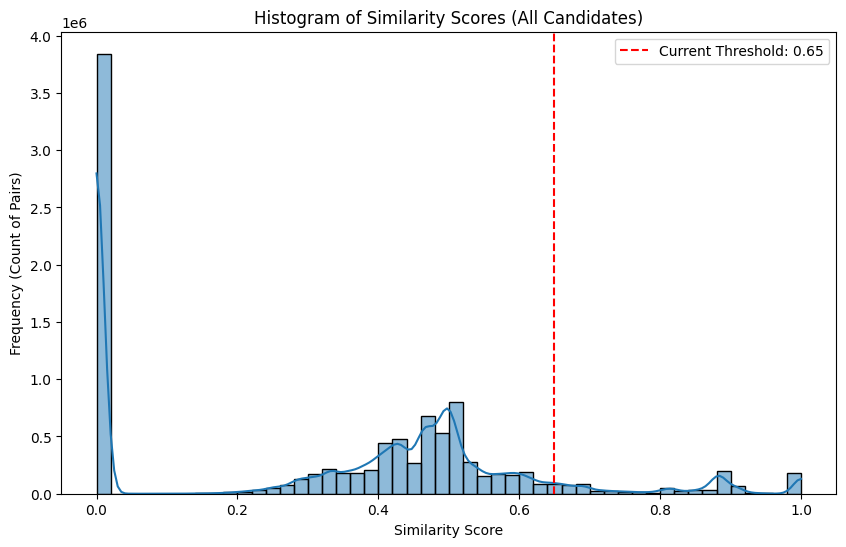

In [14]:
# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)

if isinstance(debug_info, pd.DataFrame):
    plt.figure(figsize=(10, 6))
    
    # Use seaborn to plot the histogram of all candidate scores
    # kde=True adds a smooth density line
    sns.histplot(debug_info['similarity'], bins=50, kde=True)
    
    # Add a vertical line to show your chosen threshold
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Current Threshold: {threshold}')
    
    plt.title('Histogram of Similarity Scores (All Candidates)')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency (Count of Pairs)')
    plt.legend()
    plt.show()
else:
    print("debug_info is not a DataFrame. Make sure debug=True was set in matcher.match()")

[INFO ] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO ] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


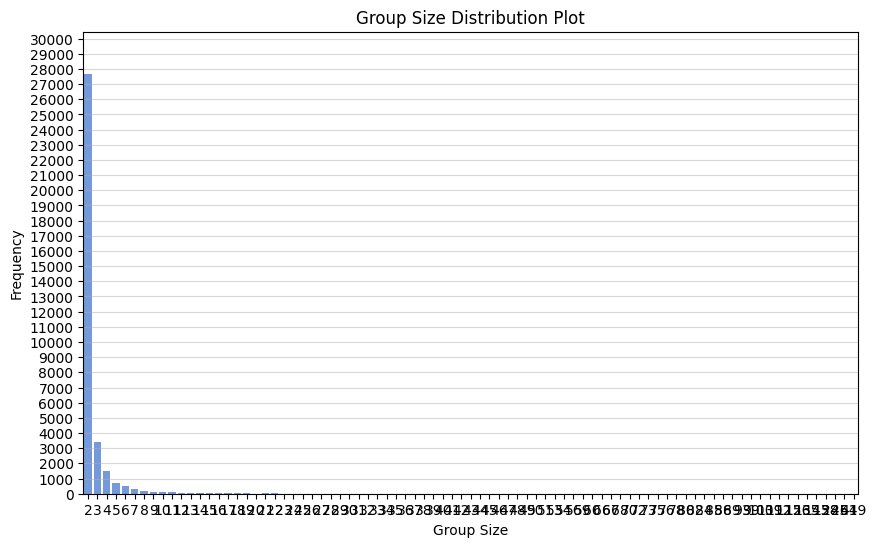

In [15]:
if isinstance(cluster_distribution, pd.DataFrame) and not cluster_distribution.empty:
    
    plt.figure(figsize=(10, 6))
    
    # --- FIX: Change column names from 'Cluster Size' to 'cluster_size' ---
    sns.barplot(
        data=cluster_distribution, 
        x='cluster_size',  # <-- Corrected column name
        y='frequency',   # <-- Corrected column name
        color='cornflowerblue'
    )
    
    # --- FIX: Update 'Frequency' here as well ---
    plt.ylim(0, cluster_distribution['frequency'].max() * 1.1)
    
    # (You may also need to update the tick calculation if max() is 0 or very small)
    max_freq = cluster_distribution['frequency'].max()
    if max_freq > 0:
        # Set y-axis to start at 0 and have integer ticks
        plt.ylim(0, max_freq * 1.1)
        
        # Adjust tick step based on max frequency
        step = max(1, 1000 if max_freq > 5000 else int(max_freq / 5)) # Dynamic step
        plt.yticks(
            ticks=range(0, int(max_freq * 1.1) + 1, step)
        )
    
    # Set labels and title to match the image
    plt.title('Group Size Distribution Plot')
    plt.xlabel('Group Size')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='-', alpha=0.5) 
    
    plt.show()
else:
    print("Cluster distribution data is empty or not in the expected DataFrame format.")

#### The One-to-One Constraint (to deal with the cluster with more than two entity)

PyDI offers the following methods for global matching:

- **GreedyOneToOneMatchingAlgorithm**: Ensures one-to-one matching by greedily selecting highest-scoring correspondences while avoiding conflicts.
- **MaximumBipartiteMatching**: Finds optimal one-to-one matching using maximum weight bipartite matching algorithms.
- **StableMatching**: Finds stable matches where records are matched to mutually preferred partners, ensuring no record would prefer to switch.

In [22]:
from PyDI.entitymatching import GreedyOneToOneMatchingAlgorithm, StableMatching, MaximumBipartiteMatching

one_to_one_algorithm = GreedyOneToOneMatchingAlgorithm()
refined_correspondences = one_to_one_algorithm.cluster(correspondences)

# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=refined_correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)

[INFO ] root - Filtered correspondences: 97448 -> 97448 (threshold=0.0)
[INFO ] root - Greedy matching: 97448 -> 42604 correspondences (85208 entities matched)
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 97448 -> 42604 correspondences
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 98897 -> 85208 entities
[INFO ] PyDI.entitymatching.evaluation - Cluster Size Distribution of 42604 clusters:
[INFO ] PyDI.entitymatching.evaluation - 	Cluster Size	| Frequency	| Percentage
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1154, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeErro

#### Run the testing set

In [23]:
eval_results = EntityMatchingEvaluator.evaluate_matching(
    correspondences=refined_correspondences,
    test_pairs=df_test,
    out_dir=debug_output_dir
)

[DEBUG] root - Individual correspondence evaluations:
[DEBUG] root - [correct] left_075781,right_004227,TRUE,sim:0.9570
[DEBUG] root - [correct] left_156878,right_020938,TRUE,sim:0.9267
[DEBUG] root - [correct] left_078843,right_022927,TRUE,sim:0.9225
[DEBUG] root - [correct] left_005668,right_016136,TRUE,sim:0.9201
[DEBUG] root - [correct] left_084812,right_039287,TRUE,sim:0.9174
[DEBUG] root - [correct] left_050461,right_046023,TRUE,sim:0.9166
[DEBUG] root - [correct] left_047721,right_060012,TRUE,sim:0.9129
[DEBUG] root - [correct] left_045926,right_035809,TRUE,sim:0.9119
[DEBUG] root - [correct] left_159591,right_055935,TRUE,sim:0.9056
[DEBUG] root - [correct] left_123135,right_055474,TRUE,sim:0.9046
[DEBUG] root - [correct] left_003156,right_054887,TRUE,sim:0.8916
[DEBUG] root - [correct] left_154889,right_018116,TRUE,sim:0.8733
[DEBUG] root - [correct] left_044547,right_025938,TRUE,sim:0.8733
[DEBUG] root - [correct] left_083481,right_055024,TRUE,sim:0.8640
[DEBUG] root - [correc

## 5. Blocking(Birthday+one word overlapping) + GPTAPI

## 6. Save the finalized file for Data Fusion

In [ ]:
correspondences_output_dir = OUTPUT_DIR / "correspondences"
correspondences_output_dir.mkdir(parents=True, exist_ok=True)

correspondences_llm_fewshot.to_pickle(f"{OUTPUT_DIR}/correspondences/correspondences_llm_fewshot.pkl") # remember to change the file name

correspondences_llm_fewshot.to_csv(f"{OUTPUT_DIR}/correspondences/correspondences_llm_fewshot.csv", index=False)

NameError: name 'correspondences_llm_fewshot' is not defined